In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import copy

from skimage import io
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms

In [2]:
class CatsDogsDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        image_name = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(image_name)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [3]:
normalize = transforms.Normalize(
    [0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225]
)

inv_normalize = transforms.Normalize(
    [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    [1/0.229, 1/0.224, 1/0.225]
)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    #normalize
])

dataset = CatsDogsDataset('train.csv', 'train', transform)

In [4]:
len(dataset)

500

In [5]:
train_data, val_data = random_split(dataset, [400, 100])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

CAT


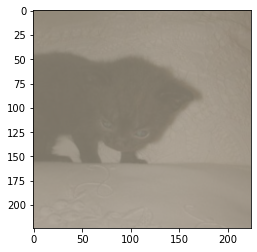

In [6]:
for images, labels in train_loader:
    image = images[0]
    label = labels[0]
    break

plt.imshow(inv_normalize(image).permute(1, 2, 0).numpy())
print('CAT' if label == 0 else 'DOG')

In [7]:
class AlexNet(nn.Module):
   
    def __init__(self, in_channels=3, num_classes=1000):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc_layers = nn.Sequential(
            nn.Dropout(),

            nn.Linear(256*6*6, 500),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, num_classes)
        )

    def forward(self, X, log_softmax=False):
        X = self.conv_layers(X)
        X = self.avgpool(X)
        X = torch.flatten(X, 1)
        X = self.fc_layers(X)
        if log_softmax:
            X = F.log_softmax(X, dim=1)
        return X

In [8]:
model = AlexNet(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
start_time = time.time()

epochs = 10
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

dataloaders = {'train':train_loader, 'val':val_loader}
dataset_sizes = {phase: len(dataloaders[phase].dataset) for phase in ['train', 'val']}

best_acc = 0

for epoch in range(epochs):
    epoch += 1
    print('Epoch {}/{}'.format(epoch, epochs))
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        elif phase == 'val':
            model.eval()
        
        running_loss = 0
        running_corrects = 0
        
        for b, (inputs, labels) in enumerate(dataloaders[phase]):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            
            optimizer.zero_grad()
            if phase == 'train':
                loss.backward()
                optimizer.step()
                
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
                
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        losses[phase].append(epoch_loss)
        accuracies[phase].append(epoch_acc)
        
        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')
        
        if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
    print()
    
time_elapsed = time.time() - start_time

print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best Validation Acc: {best_acc * 100:.2f}')

#model.load_state_dict(best_model_wts)

Epoch 1/10
----------
Train Loss: 0.7029, Accuracy: 49.00%
Val Loss: 0.6925, Accuracy: 52.00%

Epoch 2/10
----------
Train Loss: 0.6936, Accuracy: 46.00%
Val Loss: 0.6935, Accuracy: 48.00%

Epoch 3/10
----------
Train Loss: 0.6936, Accuracy: 50.50%
Val Loss: 0.6940, Accuracy: 48.00%

Epoch 4/10
----------
Train Loss: 0.6933, Accuracy: 50.75%
Val Loss: 0.6932, Accuracy: 48.00%

Epoch 5/10
----------
Train Loss: 0.6933, Accuracy: 47.00%
Val Loss: 0.6931, Accuracy: 52.00%

Epoch 6/10
----------
Train Loss: 0.6932, Accuracy: 50.75%
Val Loss: 0.6935, Accuracy: 48.00%

Epoch 7/10
----------
Train Loss: 0.6938, Accuracy: 50.50%
Val Loss: 0.6945, Accuracy: 48.00%

Epoch 8/10
----------
Train Loss: 0.6931, Accuracy: 50.50%
Val Loss: 0.6937, Accuracy: 48.00%

Epoch 9/10
----------
Train Loss: 0.6933, Accuracy: 51.00%
Val Loss: 0.6933, Accuracy: 48.00%

Epoch 10/10
----------
Train Loss: 0.6933, Accuracy: 48.25%
Val Loss: 0.6931, Accuracy: 52.00%

Training complete in 4m 50s
Best Validation Acc: 

True label: DOG
Predicted label: DOG


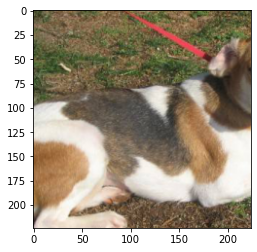

In [11]:
#filenames = []
#
#for filename in os.listdir(os.getcwd() + '/train'):
#    filenames.append(filename)
#fname = np.random.choice(filenames, 1)[0]
#image_name = os.path.join('train', fname)
#image = io.imread(image_name)
#image = transform(image)

#print(f'Filename: {fname}')
#print(f'Label {fname[:3].upper()}')

idx = 42
assert (idx >= 0 and idx < len(val_data)), f'Pick a number from 0 to {len(val_data) - 1}'
image = val_data[idx][0][None, ...]

model.eval()
with torch.no_grad():
    pred = model(image).argmax().item()
    optimizer.zero_grad()


print(f'True label: {"CAT" if val_data[idx][1].item() == 0 else "DOG"}')
print(f'Predicted label: {"CAT" if pred == 0 else "DOG"}')
plt.imshow(val_data[idx][0].permute(1, 2, 0))
plt.show()